In [1]:
!pip install gensim seaborn wordcloud rank_bm25 nltk ktrain
!pip install https://github.com/lambdaofgod/ktrain/archive/nmf_topic_modeling.zip

You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://github.com/lambdaofgod/ktrain/archive/nmf_topic_modeling.zip
     |████████████████████████████████| 13.1MB 14.9MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/f8/a1/5742b56282449b1c0968197f63eae486eca2c35dcd334bab75ad524e0de1/kiwisolver-1.1.0-cp36-cp36m-manylinux1_x86_64.whl


  Stored in directory: /tmp/pip-ephem-wheel-cache-92ql8vyq/wheels/cc/6b/78/b435e6a37a0a65fb5d06e1eaefad2922be795c3f6be3fb7730
Successfully built ktrain
  Found existing installation: matplotlib 2.1.1
    Uninstalling matplotlib-2.1.1:
      Successfully uninstalled matplotlib-2.1.1
  Found existing installation: ktrain 0.9.4
    Uninstalling ktrain-0.9.4:
      Successfully uninstalled ktrain-0.9.4
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import re
import tqdm
import requests

import numpy as np

from markdown import markdown
import nltk


import pandas as pd
from pandas.io.json import json_normalize
from gensim import summarization

from sklearn import decomposition, feature_extraction, manifold
from sklearn.feature_extraction import stop_words
from sklearn import pipeline

import rank_bm25


import seaborn as sns
import wordcloud

import matplotlib.pyplot as plt
from IPython.display import Markdown, display

import bokeh.model
import bokeh.plotting
import bokeh.io
import re

import umap
from sklearn import metrics


bokeh.io.output_notebook()

Loading BokehJS ...

In [3]:
plt.style.use('dark_background')

In [4]:
def printmd(string):
    display(Markdown(string))
    

def get_word_cloud(texts):
    text = ' '.join(texts)
    return wordcloud.WordCloud(max_font_size=40).generate(text)


def show_word_cloud(wc, figure_kwargs={'figsize': (8, 5)}):
    plt.figure(**figure_kwargs)
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

  
def show_word_cloud_from_texts(text_column):
    texts = text_column.fillna('').values
    cloud = get_word_cloud(texts)
    show_word_cloud(cloud)

Put your Github token to `github_auth_key.txt`

You have to do this because, unfortunately, for now there is no way to use GraphQL without authentication.

In [5]:
key = open('github_auth_key.txt', 'r').read().strip()

Note that I barely know GraphQL: I made this query in [Github's API explorer](https://developer.github.com/v4/explorer/)

In [6]:
headers = {'Authorization': 'token ' + key}


def run_query(query): # A simple function to use requests.post to make the API call. Note the json= section.
    request = requests.post('https://api.github.com/graphql', json={'query': query}, headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, query))

        
# The GraphQL query (with a few aditional bits included) itself defined as a multi-line string.       
def get_next_paged_result(result):
  if result is None:
    end_cursor_string = ''
  else:
    end_cursor_string = 'after: "{}"'.format(result['data']['viewer']['starredRepositories']['pageInfo']['endCursor'])
  new_query_string = """{{
    viewer {{
      starredRepositories(first: 100, {}) {{
        pageInfo {{
          startCursor
          hasNextPage
          endCursor
        }}
        nodes {{
          name
          owner {{
            login
          }}
          description
          primaryLanguage {{
            name
          }}
          repositoryTopics(first: 10) {{
            nodes {{
              topic {{
                name
              }}
            }}
          }}
          object(expression: "master:README.md") {{
            ... on Blob {{
              text
            }}
          }}
        }}
      }}
    }}
  }}""".format(end_cursor_string)
  return run_query(new_query_string)

In [7]:
def get_starred_repo_information():
    next_result = None
    starred_repo_information = []
    for __ in tqdm.tqdm(range(5)):
      next_result = get_next_paged_result(next_result)
      starred_repo_information = starred_repo_information + next_result['data']['viewer']['starredRepositories']['nodes']
    return starred_repo_information

In [8]:
starred_repo_information = get_starred_repo_information()

100%|██████████| 5/5 [00:20<00:00,  4.09s/it]


In [9]:
from nltk import stem, tokenize
lemmatizer = stem.WordNetLemmatizer()
lemmatizer.lemmatize('repositories')


def clean_and_stem(text):
    cleaned_text = re.sub('^[0-9a-zA-Z]+', ' ' , text.lower())
    return ' '.join([lemmatizer.lemmatize(w) for w in tokenize.wordpunct_tokenize(cleaned_text)])


def get_cleaned_starred_repositories_df(repo_information):
    repo_df = json_normalize(repo_information)
    repo_df.index = repo_df['name']
    repo_df.drop('name', axis=1, inplace=True)
    repo_df['primaryLanguage'] = repo_df['primaryLanguage.name']
    repo_df.drop('primaryLanguage.name', axis=1)
    repo_df['topics'] = repo_df['repositoryTopics.nodes'].apply(lambda recs: [r['topic']['name'] for r in recs])
    repo_df['topics'] = repo_df['topics'].apply(lambda ts: [lemmatizer.lemmatize(t) for t in ts])
    repo_df['description'].fillna('', inplace=True)
    repo_df['description_stemmed'] = repo_df['description'].apply(clean_and_stem)
    repo_df['description_keywords'] = repo_df['description_stemmed'].apply(summarization.keywords)
    repo_df['description_length'] = repo_df['description'].str.split().apply(lambda l: 0 if l is None else len(l))
    repo_df = repo_df[repo_df['description_length'] > 0]
    return repo_df

In [10]:
def get_topic_representant_indices(topic_weights, topic_idx, num_representants=5):
    indices = topic_weights[:, topic_idx].argsort()[::-1]
    return indices[:num_representants]


def get_repos_representing_topic(repo_df, topic_weights, topic_idx, num_representants=5):
    return repo_df.iloc[get_topic_representant_indices(topic_weights, topic_idx, num_representants)]

In [11]:
def plot_description_lengths(description_lengths):
    hist, edges = np.histogram(description_lengths.values, bins=25)
    median_description_length = description_lengths.median()
    mean_description_length = description_lengths.mean()

    p = bokeh.plotting.figure(
        title='Description length',
        x_axis_label='words in description',
        y_axis_label='number of repositories',
        plot_height=600, plot_width=800)
    p.quad(top=hist, left=edges[:-1], right=edges[1:], bottom=0)
    p.line([median_description_length, median_description_length], [0, 140], line_color='red')
    bokeh.plotting.show(p)

In [12]:
from bokeh import palettes


def plot_2d_data(data, text_label, cls, show_text=True, subset=None):
    palette = palettes.d3['Category20']
    x, y = data[:, 0], data[:, 1]
    source_df = pd.DataFrame({'x': x, 'y': y, 'text_label': text_label, 'color': [palette[c + 3][c] for c in cls]})
    source = bokeh.models.ColumnDataSource(source_df)

    TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,"
    
    p = bokeh.plotting.figure(tools=TOOLS, plot_width=800, plot_height=600)
    p.scatter(x='x', y='y', source=source, fill_color='color', line_color='color')


    if subset is not None:
        text_labels = bokeh.models.LabelSet(x='x', y='y', text='text_label', level='glyph',
                      x_offset=5, y_offset=5, source=bokeh.models.ColumnDataSource(source_df.iloc[subset]), render_mode='canvas', text_font_size='7pt')
        p.add_layout(text_labels)
    bokeh.plotting.show(p)

In [13]:
starred_repo_df = get_cleaned_starred_repositories_df(starred_repo_information)

Primary language

In [14]:
language_counts = starred_repo_df['primaryLanguage'].fillna('unspecified').value_counts()

# Programming language

In [15]:
p = bokeh.plotting.figure(x_range=list(language_counts.index), title='Repository number by language')

p.vbar(x=language_counts.index, top=language_counts, width=1)
p.xaxis.major_label_orientation = "vertical"
bokeh.plotting.show(p)

In [16]:
print(starred_repo_df['description_length'].describe())
plot_description_lengths(starred_repo_df['description_length'])

count    486.000000
mean      10.125514
std        6.489221
min        1.000000
25%        6.000000
50%        9.000000
75%       12.000000
max       69.000000
Name: description_length, dtype: float64


In [17]:
starred_repo_df = starred_repo_df[starred_repo_df['description_length'] > 5]

# Topics word cloud

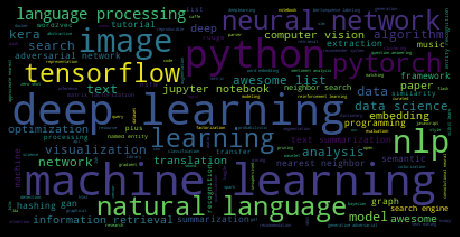

In [18]:
show_word_cloud_from_texts(starred_repo_df['topics'].apply(' '.join))

Descriptions word cloud

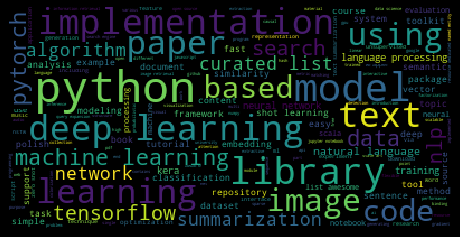

In [19]:
show_word_cloud_from_texts(starred_repo_df['description_stemmed'])

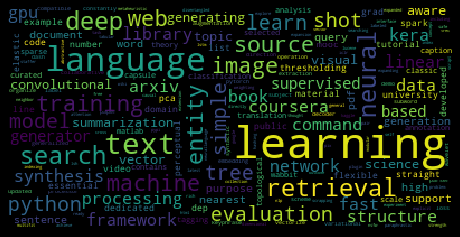

In [20]:
show_word_cloud_from_texts(starred_repo_df['description_keywords'])

# Information retrieval crash course

We have a collection of documents $d_i$ and want to find some documents. 

We formulate a query $q$ for which the system returns some documents with relevance scores.

System can be evaluated (for queries with known responses) as a classifier.

Because of that we use precision and recall scores (why these instead of accuracy?)

Also we can use ranking metrics.

## Approaches

- substring matching

- break down texts into word and match them

## Honorable mention - inverted index


## The Vector Space Model

- represent documents and queries as vectors

- use similarity/disssimilarity (distance) to score vectors for a query

### Bag of Words

- TF-IDF, BM-25 can be interpreted as this - similarity is calculated as dot product in appropriate space

- `sklearn.text.preprocessing.{Count|TfIdf}Vectorizer`

**Now we can use machine learning!**

In [21]:
import rank_bm25 


class SearchEngine:
    
    def __init__(self, df, bm25_cls=rank_bm25.BM25Okapi, text_col='text'):
        self.bm25 = bm25_cls(df[text_col].str.split())
        self.df = df
        
    def search(self, query, k=100):
        scores = self.bm25.get_scores(query.split())
        #scores = scores[scores > 0]
        relevant_indices = np.argsort(-scores)[:k]
        return self.df.iloc[relevant_indices[scores[relevant_indices] > 0]]

    
search_engine = SearchEngine(starred_repo_df, text_col='description_stemmed')
search_engine.search('information retrieval')

,description,owner.login,primaryLanguage.name,repositoryTopics.nodes,object.text,primaryLanguage,object,topics,description_stemmed,description_keywords,description_length
name,,,,,,,,,,,
musicinformationretrieval.com,Instructional notebooks on music information r...,stevetjoa,Jupyter Notebook,"[{'topic': {'name': 'ipython-notebook'}}, {'to...",stanford-mir\n============\n\n[![Stories in Re...,Jupyter Notebook,NaN,"[ipython-notebook, music-information-retrieval...",notebook on music information retrieval .,,6
awesome-information-retrieval,A curated list of awesome information retrieva...,harpribot,NaN,[],# Awesome Information Retrieval [![Awesome](ht...,NaN,NaN,[],curated list of awesome information retrieval ...,retrieval,8
LIRE,Open source library for content based image re...,dermotte,Java,"[{'topic': {'name': 'image-retrieval'}}, {'top...",# LIRE - Lucene Image Retrieval\nLIRE (Lucene ...,Java,NaN,"[image-retrieval, lira, multimedia]",source library for content based image retriev...,retrieval,12
pytrec_eval,pytrec_eval is an Information Retrieval evalua...,cvangysel,C++,"[{'topic': {'name': 'information-retrieval'}},...",pytrec_eval\n===========\n\npytrec\_eval is a ...,C++,NaN,"[information-retrieval, evaluation]",_eval is an information retrieval evaluation t...,evaluation,14
query-expansion,Developing different methods for expanding a q...,phosseini,Python,[],# query-expansion\n\nThis repository is dedica...,Python,NaN,[],different method for expanding a query / topic...,expanding\nquery\nexpanded,19
cnnimageretrieval-pytorch,CNN Image Retrieval in PyTorch: Training and e...,filipradenovic,Python,"[{'topic': {'name': 'image-retrieval'}}, {'top...",## CNN Image Retrieval in PyTorch: Training an...,Python,NaN,"[image-retrieval, convolutional-neural-network...",image retrieval in pytorch : training and eval...,image,14
revisitop,Revisiting Oxford and Paris: Large-Scale Image...,filipradenovic,Python,"[{'topic': {'name': 'image-retrieval'}}, {'top...",# Revisiting Oxford and Paris: Large-Scale Ima...,Python,NaN,"[image-retrieval, matlab, python]",oxford and paris : large - scale image retriev...,retrieval,8
sparse_recovery,noiseless/nonnegative sparse recovery and feat...,NLPrinceton,Python,[],# sparse_recovery\n\nThis module provides solv...,Python,NaN,[],/ nonnegative sparse recovery and feature retr...,sparse,9
CBIR,🏞 A content-based image retrieval (CBIR) system,pochih,Python,"[{'topic': {'name': 'image-retrieval'}}, {'top...",[![Open Source Love](https://badges.frapsoft.c...,Python,NaN,"[image-retrieval, computer-vision, gabor, hog,...",🏞 a content - based image retrieval ( cbir ) s...,retrieval,7


### BM25 - a comment

BM comes from 'Best Match'

Difference between TF-IDF: is not symmetrical (query and documents are treated in a different way, for example because their lengths tend to differ) 

# Bag of Words

Pros:

- can be very fast
- easy to vectorize
- good if you actually want to search by phrase
    
Cons:

- extremely high dimensionality - use sparse vectors or die (waiting or RAM)
- troubles with polysemous words
- vocabulary mismatch problem - synonymy

In [22]:
from sklearn import feature_extraction 

vectorizer = feature_extraction.text.TfidfVectorizer(ngram_range=(1,2))
term_document_matrix = vectorizer.fit_transform(starred_repo_df['description_stemmed']) 
term_document_matrix.shape

(394, 4389)

In [23]:
search_engine.search('image')

,description,owner.login,primaryLanguage.name,repositoryTopics.nodes,object.text,primaryLanguage,object,topics,description_stemmed,description_keywords,description_length
name,,,,,,,,,,,
open-images,Build an example image classifier using Google...,quiltdata,Jupyter Notebook,[],# open images\n\nThis repository contains the ...,Jupyter Notebook,NaN,[],an example image classifier using google open ...,image,10
nsfw_data_source_urls,Collection of NSFW images URLs for the purpose...,EBazarov,NaN,[],# NSFW data source URLs\n\n## Description\n\nR...,NaN,NaN,[],of nsfw image url for the purpose of training ...,,14
FUNIT_tensorflow,Tensorflow Implementation of FUNIT: Few-Shot U...,zhangqianhui,Python,[{'topic': {'name': 'image-to-image-translatio...,# FUNIT_tensorflow\nTensorflow Implementation ...,Python,NaN,"[image-to-image-translation, few-shot-learning...",implementation of funit : few - shot unsupervi...,,8
cnnimageretrieval-pytorch,CNN Image Retrieval in PyTorch: Training and e...,filipradenovic,Python,"[{'topic': {'name': 'image-retrieval'}}, {'top...",## CNN Image Retrieval in PyTorch: Training an...,Python,NaN,"[image-retrieval, convolutional-neural-network...",image retrieval in pytorch : training and eval...,image,14
imagehash,A Python Perceptual Image Hashing Module,JohannesBuchner,Python,[],NaN,Python,NaN,[],python perceptual image hashing module,perceptual,6
nsfw_data_scraper,Collection of scripts to aggregate image data ...,alex000kim,Shell,"[{'topic': {'name': 'nsfw-classifier'}}, {'top...",# NSFW Data Scraper\n\n## Note: use with cauti...,Shell,NaN,"[nsfw-classifier, nsfw, deep-learning, content...",of script to aggregate image data for the purp...,image,16
image-to-image-papers,🦓<->🦒 🌃<->🌆 A collection of image to image pa...,lzhbrian,NaN,"[{'topic': {'name': 'image-to-image'}}, {'topi...",# Image-to-Image papers\n\nA collection of ima...,NaN,NaN,"[image-to-image, generative-adversarial-networ...",🦓<->🦒 🌃<->🌆 a collection of image to image pap...,constantly,13
snowy,Small Image Library for Python 3,prideout,Python,"[{'topic': {'name': 'python'}}, {'topic': {'na...",[![Build Status](https://travis-ci.org/prideou...,Python,NaN,"[python, image-processing]",small image library for python 3,,6
image-match,🎇 Quickly search over billions of images,EdjoLabs,Python,"[{'topic': {'name': 'image-analysis'}}, {'topi...",[![PyPI](https://img.shields.io/pypi/status/im...,Python,NaN,"[image-analysis, image-signatures, python, sea...",🎇 quickly search over billion of image,,7


In [24]:
search_engine.search('picture')

,description,owner.login,primaryLanguage.name,repositoryTopics.nodes,object.text,primaryLanguage,object,topics,description_stemmed,description_keywords,description_length
name,,,,,,,,,,,


## Can we do anything with nonexact matches?

- use different representation (word embeddings et c)

- change original representation

## Dimensionality reduction on text

- Latent Semantic Indexing (`sklearn.decomposition.TruncatedSVD`)

- topic models

## Topic modeling (repo descriptions)

Idea - documents are probability distributions over vocabulary

Model documents as mixtures of several latent factors 

This can be also considered as soft clustering (and turned into clustering by recovering the biggest component)

I used LDA and NMF here, chose NMF because results looked better

## TL;DR NMF is a simpler model than LDA, probably better here since we have only ~500 examples 

## Nonnegative Matrix Factorization

Assume $t$ number of topics.

Find nonnegative $L, T$ minimizing

$\|\underset{n \times v}{D} - \underset{n \times t}{L}\ \underset{t \times D}{T}\|^2_F$

Similar to PCA (rank constraint)

Can also add regularization

In [25]:
import ktrain

num_topics = 10 
tm = ktrain.text.get_topic_model(
    starred_repo_df['description_stemmed'],
    n_topics=num_topics,
    model_type='nmf',
    n_features=term_document_matrix.shape[1],
    lda_max_iter=100,
    min_df=2,
    verbose=0,
    hyperparam_kwargs={'nmf_alpha': 0.05, 'ngram_range': (1,2)}
)

using Keras version: 2.2.4-tf


In [26]:
tm.build(starred_repo_df['description_stemmed'])

In [27]:
tm.print_topics(show_counts=True)

topic:1 | count:43 | python library causal module data using implementation model retrieval python implementation
topic:5 | count:30 | text network summarization neural neural network model text summarization using extractive paper
topic:0 | count:22 | learning deep deep learning book learning model learning book http interactive notebook exercise
topic:9 | count:20 | image retrieval pytorch image retrieval implementation nsfw training based nsfw image image classifier
topic:3 | count:19 | learning machine machine learning scalable factorization machine factorization linear scalable machine library source
topic:2 | count:19 | language processing language processing natural natural language nlp processing nlp art state state art
topic:8 | count:17 | list curated list curated resource awesome list awesome dedicated list resource resource dedicated tutorial
topic:6 | count:16 | search com vector expansion engine search engine talk query semantic query expansion
topic:7 | count:9 | learnin

In [28]:
reduced_term_document_matrix = tm.predict(starred_repo_df['description_stemmed'])
representative_repos = [get_repos_representing_topic(starred_repo_df, reduced_term_document_matrix, topic)[['description_stemmed']] for topic in range(num_topics)]

## Topic keywords and most representative repositories

------
# Topic 1
------

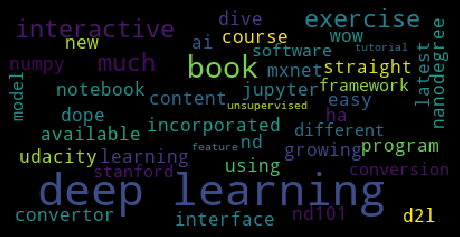

# Keywords

{'book',
 'deep',
 'exercise',
 'http',
 'interactive',
 'learning',
 'model',
 'notebook'}

## **repositories representative for 1th topic:**

,description_stemmed
name,
mxnet-the-straight-dope,interactive book on deep learning . much easy ...
d2l-en,into deep learning : an interactive deep learn...
deep-learning-v2-pytorch,and exercise for the latest deep learning nd p...
deep-learning-model-convertor,convertor / conversion of deep learning model ...
stanford_dl_ex,exercise for the stanford unsupervised feature...


------
# Topic 2
------

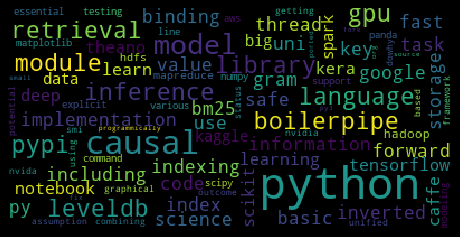

# Keywords

{'causal',
 'data',
 'implementation',
 'library',
 'model',
 'module',
 'python',
 'retrieval',
 'using'}

## **repositories representative for 2th topic:**

,description_stemmed
name,
ir-python,python implementation for information retrieva...
data-science-ipython-notebooks,science python notebook : deep learning ( tens...
dowhy,is a python library for causal inference that ...
gputil,python module for getting the gpu status from ...
boilerpipe3,fork of boilerpipe with python 3 and small fix...


------
# Topic 3
------

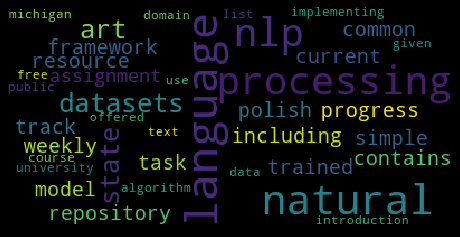

# Keywords

{'art', 'language', 'natural', 'nlp', 'processing', 'state'}

## **repositories representative for 3th topic:**

,description_stemmed
name,
NLP-progress,to track the progress in natural language proc...
flair,very simple framework for state - of - the - a...
polish-nlp-resources,- trained model and language resource for natu...
Introduction-to-Natural-Language-Processing-UMich-Coursera,repository contains weekly assignment on imple...
nlp-datasets,list of free / public domain datasets with tex...


------
# Topic 4
------

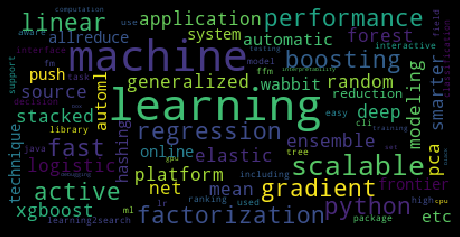

# Keywords

{'factorization',
 'learning',
 'library',
 'linear',
 'machine',
 'scalable',
 'source'}

## **repositories representative for 4th topic:**

,description_stemmed
name,
h2o-3,source fast scalable machine learning platform...
vowpal_wabbit,wabbit is a machine learning system which push...
xlearn,"performance , easy - to - use , and scalable m..."
catboost,"fast , scalable , high performance gradient bo..."
nlpday-workshop-2018,with training and testing set : active learnin...


------
# Topic 5
------

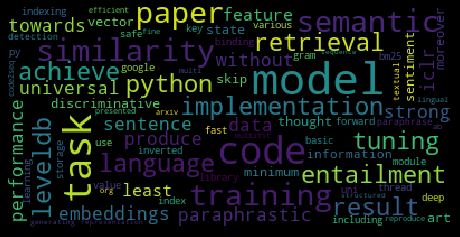

# Keywords

{'code',
 'data',
 'model',
 'paper',
 'semantic',
 'sentence',
 'similarity',
 'task',
 'training'}

## **repositories representative for 5th topic:**

,description_stemmed
name,
iclr2016,code for training all model in the iclr paper ...
ir-python,python implementation for information retrieva...
sentence-similarity,implementation of various deep learning model ...
multifit,"code to reproduce result from paper "" multifit..."
code2seq,"for the model presented in the paper : "" code2..."


------
# Topic 6
------

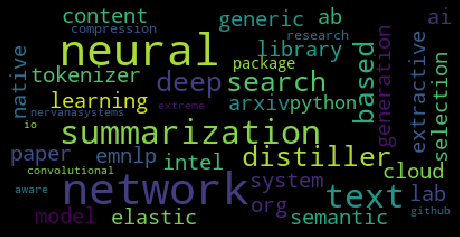

# Keywords

{'extractive',
 'model',
 'network',
 'neural',
 'paper',
 'summarization',
 'text',
 'using'}

## **repositories representative for 6th topic:**

,description_stemmed
name,
nnsum,extractive neural network text summarization l...
sentencepiece,text tokenizer for neural network - based text...
gnes,"is generic neural elastic search , a cloud - n..."
distiller,network distiller by intel ai lab : a python p...
XSum,- aware convolutional neural network for extre...


------
# Topic 7
------

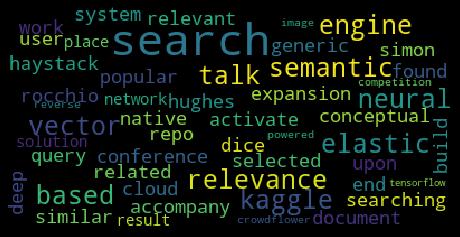

# Keywords

{'com', 'engine', 'expansion', 'query', 'search', 'semantic', 'talk', 'vector'}

## **repositories representative for 7th topic:**

,description_stemmed
name,
VectorsInSearch,. com repo to accompany the dice . com ' vecto...
columbiau-rocchio-search-query-expander,"rocchio query expansion - similar to "" related..."
gnes,"is generic neural elastic search , a cloud - n..."
Kaggle_CrowdFlower,place solution for search result relevance com...
Image-to-Image-Search,reverse image search engine powered by elastic...


------
# Topic 8
------

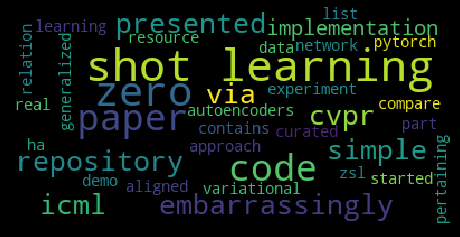

# Keywords

{'code',
 'learning',
 'paper',
 'presented',
 'repository',
 'shot',
 'simple',
 'zero'}

## **repositories representative for 8th topic:**

,description_stemmed
name,
LearningToCompare_ZSL,code for cvpr 2018 paper : learning to compare...
Embarrassingly-simple-ZSL,repository contains the code for the real data...
embarrassingly-simple-zero-shot-learning,is a started / demo code for zero - shot - lea...
Generalized-Zero-Shot-Learning-via-Aligned-Variational-Autoencoders,repository ha the pytorch implementation of th...
awesome-zero-shot-learning,"curated list of paper , code and resource pert..."


------
# Topic 9
------

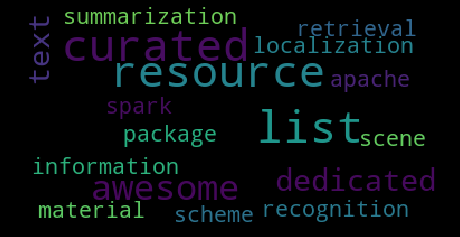

# Keywords

{'awesome', 'curated', 'dedicated', 'list', 'resource', 'tutorial'}

## **repositories representative for 9th topic:**

,description_stemmed
name,
awesome-spark,curated list of awesome apache spark package a...
awesome-information-retrieval,curated list of awesome information retrieval ...
awesome-scheme,curated list of awesome scheme resource and ma...
Awesome-Scene-Text-Recognition,curated list of resource dedicated to scene te...
awesome-text-summarization,curated list of resource dedicated to text sum...


------
# Topic 10
------

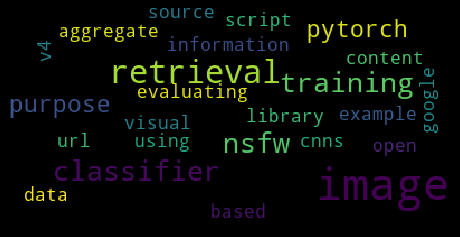

# Keywords

{'based',
 'classifier',
 'image',
 'implementation',
 'nsfw',
 'pytorch',
 'retrieval',
 'training'}

## **repositories representative for 10th topic:**

,description_stemmed
name,
cnnimageretrieval-pytorch,image retrieval in pytorch : training and eval...
nsfw_data_source_urls,of nsfw image url for the purpose of training ...
nsfw_data_scraper,of script to aggregate image data for the purp...
LIRE,source library for content based image retriev...
open-images,an example image classifier using google open ...


In [29]:
topic_words = tm.get_topics()

for topic in range(num_topics):
    printmd("""------\n# Topic {}\n------""".format(topic+1))
    show_word_cloud_from_texts(representative_repos[topic]['description_stemmed'])
    printmd('# Keywords')
    display(set(topic_words[topic].split()))
    printmd('## **repositories representative for {}th topic:**'.format(topic + 1))
    display(representative_repos[topic])
    print()

In [30]:
tm.train_recommender(n_neighbors=3, metric='cosine')

In [31]:
def show_results(query):
    for res in tm.recommend(query, n=5, n_neighbors=3):
        print(res[0])
        print()

show_results('search')

and memory - efficient ann with a subset - search functionality

place solution for search result relevance competition on kaggle ( http :// www . kaggle . com / c / crowdflower - search - relevance )

rocchio query expansion - similar to " related search :" found at popular search engine but based on relevant document selected by the end - user

search engine with query expansion

. com repo to accompany the dice . com ' vector in search ' talk by simon hughes , from the activate 2018 search conference , and the ' searching with vector ' talk from haystack 2019 ( u ). build upon my conceptual search and semantic search work from 2015



In [32]:
show_results('query')

and memory - efficient ann with a subset - search functionality

place solution for search result relevance competition on kaggle ( http :// www . kaggle . com / c / crowdflower - search - relevance )

rocchio query expansion - similar to " related search :" found at popular search engine but based on relevant document selected by the end - user

search engine with query expansion

. com repo to accompany the dice . com ' vector in search ' talk by simon hughes , from the activate 2018 search conference , and the ' searching with vector ' talk from haystack 2019 ( u ). build upon my conceptual search and semantic search work from 2015



In [33]:
show_results('information retrieval')

source library for content based image retrieval / visual information retrieval .

image detector with rest interface developed using kera and flask

oxford and paris : large - scale image retrieval benchmarking

localize and identify multiple object in a single image .

, mobilenetv2 , vgg based ssd / ssd - lite implementation in pytorch 1 . 0 / pytorch 0 . 4 . out - of - box support for retraining on open image dataset . onnx and caffe2 support . experiment idea like coordconv .



## Visualizing repository 2D projection

Remark: ktrain also has visualization capability but I liked UMAP better

In [34]:
umap_red = umap.UMAP(metric='precomputed') 
umap_features = umap_red.fit_transform(metrics.pairwise.cosine_distances(reduced_term_document_matrix, reduced_term_document_matrix))

In [35]:
representatives = pd.concat(representative_repos)

In [36]:
representative_indices = np.where(starred_repo_df.index.isin(representatives.index))

In [37]:
plot_2d_data(
    umap_features,
    starred_repo_df.index,
    cls=np.argmax(reduced_term_document_matrix, axis=1),
    subset=representative_indices)

# More

* [my github profile - lambdaofgod](https://github.com/lambdaofgod)

* [GitHub GraphQL API](https://developer.github.com/v4/)

* [Information Retrieval book](https://nlp.stanford.edu/IR-book/information-retrieval-book.html)
* [LDA, Sparse Coding, Matrix Factorization and All That](https://www.cs.cmu.edu/~epxing/Class/10708-15/slides/LDA_SC.pdf)
* [ktrain](https://github.com/amaiya/ktrain) on github
* [BM25](https://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html)
* [UMAP](https://github.com/lmcinnes/umap)

# Using Transformers

In [ ]:
import torch
roberta = torch.hub.load('pytorch/fairseq', 'roberta.large')
roberta.eval()  # disable dropout (or leave in train mode to finetune)

In [ ]:
%%time
def get_roberta_features(text):
    return roberta.extract_features(roberta.encode(text)).detach().numpy()[0]

description_roberta_features = starred_repo_df['description'].apply(get_roberta_features)

In [ ]:
class EmbeddingSearchEngine:
    
    def __init__(self, embedder, texts=None, features=None):
        self.embedder = embedder
        if features == None:
            self.features = list(map(partial(get_embedder_features, embedder=embedder))))
        
    def search()

In [ ]:
n = len(description_roberta_features)
description_distances = np.zeros((n, n))

In [ ]:
from sklearn import metrics
import ot

In [ ]:
def get_optimal_transport_distance(v, w, sinkhorn_method='sinkhorn_stabilized'):
    dists = metrics.pairwise.euclidean_distances(v, w) ** 2
    transport = ot.sinkhorn([], [], dists, 0.1, method=sinkhorn_method, numItermax=100)
    cost = (dists * transport).sum()
    return cost 

In [ ]:
v = description_roberta_features[0] 
w = description_roberta_features[1] 

In [ ]:
%%timeit 
get_optimal_transport_distance(v, w)

In [ ]:
from concurrent.futures import ProcessPoolExecutor

In [ ]:
pool = ProcessPoolExecutor()

ds = []
for i in tqdm.tqdm(range(n)):
    v = description_roberta_features[i]
    def _map_fn(w):
        return get_optimal_transport_distance(v, w)
    v_distances = pool.map(_map_fn, [description_roberta_features[j] for j in range(i, n)], chunksize=10)
    ds.append(np.array(list(v_distances)))

In [ ]:
distances = np.zeros((n, n))
for i, d in enumerate(ds):
    distances[i, i:] = d
distances = distances + distances.T

In [ ]:
sns.heatmap(distances)

In [ ]:
roberta_mds = manifold.MDS(n_components=2, metric='precomputed')

roberta_mds_features = roberta_mds.fit_transform(distances)

In [ ]:
plot_2d_data(roberta_mds_features[representative_indices], starred_repo_df.index[representative_indices])